In [2]:
import numpy as np
import pandas as pd
import math

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline

import itertools
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
colab_path = 'ScadaData.txt'
local_path = 'C:\\Users\\hanna\\Desktop\\data\\ScadaData.txt'

scada_data = pd.read_csv(colab_path, delimiter='\t',  parse_dates=True)
scada_data['dtTimeStamp'] = pd.to_datetime(scada_data['dtTimeStamp'])

average_mean_wind_speeds = scada_data[['dtTimeStamp','WindSpeedMean', 'intObjectId']].groupby('dtTimeStamp').median()[['WindSpeedMean']]
print(average_mean_wind_speeds)

                     WindSpeedMean
dtTimeStamp                       
2019-08-01 00:00:00            2.7
2019-08-01 00:10:00            2.9
2019-08-01 00:20:00            3.8
2019-08-01 00:30:00            4.3
2019-08-01 00:40:00            4.8
...                            ...
2019-09-30 23:20:00            7.0
2019-09-30 23:30:00            7.0
2019-09-30 23:40:00            6.9
2019-09-30 23:50:00            6.9
2019-10-01 00:00:00            6.8

[8785 rows x 1 columns]


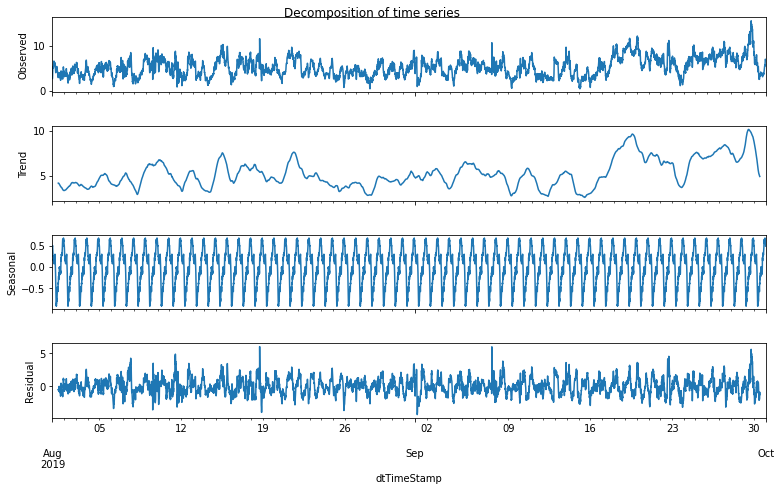

In [4]:
decomposition = sm.tsa.seasonal_decompose(average_mean_wind_speeds["WindSpeedMean"], freq=int((24*60)/10))
fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of time series')
plt.show()

Text(0.5, 1.0, 'Moving Average')

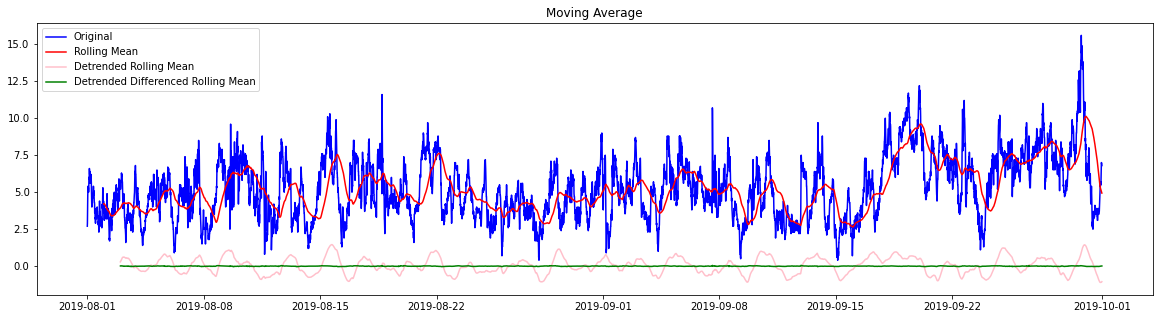

In [5]:
plt.figure(figsize=(20,5))

window=144

rolling_average = average_mean_wind_speeds.rolling(window=window).mean()
detrended = (average_mean_wind_speeds['WindSpeedMean'] - average_mean_wind_speeds['WindSpeedMean'].rolling(window=window).mean()) / average_mean_wind_speeds['WindSpeedMean'].rolling(window=window).std()
detrended_differenced = detrended-detrended.shift(1)

plt.plot(average_mean_wind_speeds, color='blue', label='Original')
plt.plot(rolling_average, color='red', label='Rolling Mean')
plt.plot(detrended.rolling(window=window).mean(), color='pink', label='Detrended Rolling Mean')
plt.plot(detrended_differenced.rolling(window=window).mean(), color='green', label='Detrended Differenced Rolling Mean')

plt.legend(loc='best')
plt.title('Moving Average')

In [6]:
def test_stationary(timeseries, window=12):
  # Rolling statistics
  movingAverage = timeseries.rolling(window=window).mean()
  movingSTD = timeseries.rolling(window=window).std()

  # Plot rolling statistics
  plt.figure(figsize=(20,5))
  plt.plot(timeseries, color='blue', label='Original')
  plt.plot(movingAverage, color='red', label='Rolling Mean')
  plt.plot(movingSTD, color='black', label='Rolling Std')
  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation\n')
  plt.show(block=False)

  # Dickey Fuller test
  print('Results of Dickey Fuller Test:\n')
  dftest = adfuller(timeseries['WindSpeedMean'], autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'No. of Lags used', 'Number of observations used'])
  for key,value in dftest[4].items():
      dfoutput['Critical Value (%s)' %key] = value
  print(dfoutput)

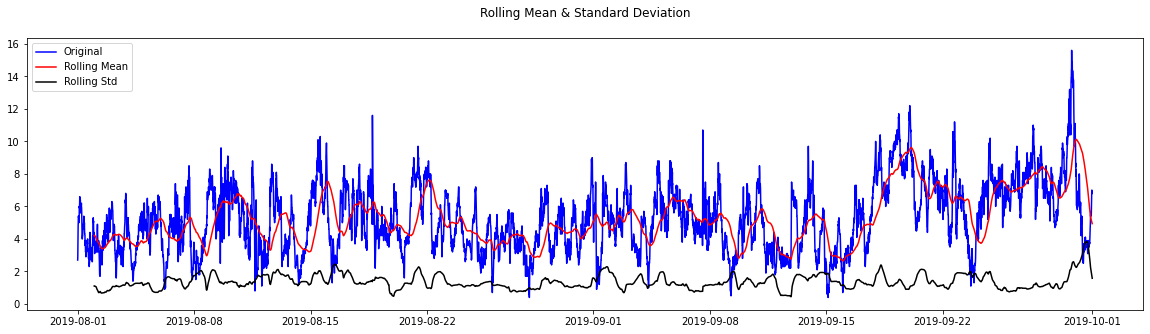

Results of Dickey Fuller Test:

Test Statistic                -9.159258e+00
p-value                        2.559361e-15
No. of Lags used               2.000000e+00
Number of observations used    8.782000e+03
Critical Value (1%)           -3.431095e+00
Critical Value (5%)           -2.861869e+00
Critical Value (10%)          -2.566945e+00
dtype: float64


In [7]:
test_stationary(average_mean_wind_speeds, window=window)

In [8]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], window) for x in list(itertools.product(p, d, q))]

print(pdq)

print(seasonal_pdq)

[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]
[(0, 0, 0, 144), (0, 0, 1, 144), (0, 1, 0, 144), (0, 1, 1, 144), (1, 0, 0, 144), (1, 0, 1, 144), (1, 1, 0, 144), (1, 1, 1, 144)]


In [ ]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

for param in pdq:
  for param_seasonal in seasonal_pdq:
    try:     
      temp_model = sm.tsa.statespace.SARIMAX(average_mean_wind_speeds,
                                            order = param,
                                            seasonal_order = param_seasonal,
                                            enforce_stationarity=True,
                                            enforce_invertibility=True)
      results = temp_model.fit()
      if results.aic < best_aic:
        best_aic = results.aic
        best_pdq = param
        best_seasonal_pdq = param_seasonal

        print(best_pdq)
        print(best_seasonal_pdq)
    except Exception as e:
        continue


print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

(0, 0, 0)
(0, 0, 0, 144)


In [ ]:
a = []
while(1):
    a.append('1')